In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.append('../../src')

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd 

from tqdm.auto import tqdm
import pickle
from pathlib import Path

# Tab1: Relative pose estimation on ScanNet
Don't forget to manually add Notes and headers Type and Methods

In [4]:
d = {'Type': [None],
     'Method': [None],
     'mAA@5': None,
     'mAA@10':None,
     'mAA@20': None}


d = pd.DataFrame.from_dict(d)

d.loc[0] = ['detector-based', 'SIFT [2004] \cite{lowe2004distinctive} + MNN + Lowe *', 5.89, 14.12, 24.89]
d.loc[2] = ['detector-based', 'ORB [2011] \cite{rublee2011orb} + MNN + Lowe *', 3.90, 9.95, 18.89]
d.loc[3] = ['detector-based', 'SuperPoint [2018] \cite{detone2018superpoint} + SuperGlue [2020] \cite{sarlin2020superglue}', 16.16,  33.81,  51.84]
d.loc[4] = ['semi-dense', 'LoFTR [2021] \cite{sun2021loftr}', 22.06, 40.8, 57.96]
d.loc[5] = ['semi-dense', '3DG-STFM Student [2022] \cite{mao20223dg}', 23.6, 43.6, 61.2]
d.loc[6] = ['semi-dense', 'QuadTree-B [2022] \cite{tang2022quadtree}', 24.9, 44.7, 61.6]
d.loc[7] = ['semi-dense', 'MatchFormer [2022] \cite{wang2022matchformer}', 24.3, 43.9, 61.4]
d.loc[8] = ['semi-dense', 'ASpanFormer [2022] \cite{chen2022aspanformer}', 25.6, 46.0, 63.3]
d.loc[9] = ['semi-dense', 'DKM [2022] \cite{edstedt2022deep}', 24.8, 44.4, 61.9]
d.loc[10] = ['end-to-end', 'Multi-view end-to-end [2022] \cite{roessle2022end2end}', 25.7, 47.2, 66.4]
# d.loc[10] = ['end-to-end', 'GrelPose [2022] \cite{khatib2022grelpose} *', None, None, None] # No code
d.loc[11] = ['end-to-end', 'DEPO-C: PVT-L + QT-B + Spatial pred.', 0., 0., 0.]


d = d.set_index(['Type', 'Method']).style.format(precision=1)

(d.highlight_max(
    axis=0,
    subset=d.columns,
    props='itshape:;'
).format_index(escape="latex", axis=1)
.background_gradient(cmap="RdYlGn", subset="mAA@5")
 .background_gradient(cmap="RdYlGn", subset="mAA@10")
 .background_gradient(cmap="RdYlGn", subset="mAA@20"))

d.index.names = [None, None]
d.to_latex(
    buf='/home/project/code/results/paper/tab_1_scannet_relative.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Relative pose estimation on ScanNet',
    label='tab:scannet_rel',
    hrules=True,
    clines='skip-last;data'
)

d
#* - estimated by me 

# Tab2: Relative pose estimation on ScanNet with magnitude prediction


In [112]:
with open('/home/project/code/results/scannet/metrics_depo', 'rb') as f:
    metrics_depo_ = pickle.load(f)
    
metrics_depo = {}
for key, val in metrics_depo_.items():
    key_corrected = key.replace('Spatial.', 'Spatial')
    metrics_depo.update({key_corrected:val})

In [113]:
with open('/home/project/code/results/scannet/metrics_gmflow', 'rb') as f:
    metrics_gmflow = pickle.load(f)

In [114]:
metrics_depo.pop('DEPO-C: PVT-L + QT-B + Spatial pred. (relative)');
metrics_gmflow.pop('GMFlow pretrained + shallow, ft 2 stages');

In [115]:
metrics = metrics_depo
metrics.update(metrics_gmflow)

In [116]:
dict_rename = {
    'GMFlow pretrained + shallow, all stages': 'GMFlow + Spatial pred., all stages ft',
    'GMFlow pretrained + shallow, w/o ft': 'GMFlow + Spatial pred., w/o ft',
    'LaDEPO-C: PVT-L + QT-B + latent': 'LaDEPO-C: PVT-L + QT-B + Latent pred.'}

for old_name, new_name in dict_rename.items():
    metrics[new_name] = metrics[old_name]
    metrics.pop(old_name)

In [118]:
df = pd.DataFrame(index=metrics.keys())

for q in (0.25, 0.5, 0.75, 0.9):
    df[f'$R_e^{q}$'] = None
    df[f'$t_e^{q}$'] = None
    for key, val in metrics.items():
        df.loc[key, f'$t_e^{q}$'] = np.quantile(val["t_distances_l2"], q)
        df.loc[key, f'$R_e^{q}$'] = np.quantile(val["R_angle_distances"], q)
df.sort_index(axis=1, inplace=True)

d = df.style.format(precision=2)
for col in df.columns:
    d.background_gradient(cmap="RdYlGn_r", subset=col)

d.to_latex(
    buf='/home/project/code/results/paper/tab_2_scannet_absolute.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Results for relative pose estimation with magnitude on ScanNet dataset',
    label='tab:scannet_abs',
    hrules=True,
    clines='skip-last;data'
)

d

,$R_e^0.25$,$R_e^0.5$,$R_e^0.75$,$R_e^0.9$,$t_e^0.25$,$t_e^0.5$,$t_e^0.75$,$t_e^0.9$
DEPO-A: PCPVT-L + QT-B + Spatial pred.,7.18,13.70,27.76,57.63,0.27,0.57,1.11,1.96
DEPO-B: PCPVT-L + QT-B + Spatial pred.,6.45,12.29,25.68,55.30,0.24,0.50,0.99,1.84
DEPO-C: PCPVT-L + QT-B + Spatial pred.,4.65,8.11,16.08,44.58,0.20,0.42,0.87,1.76
DEPO-C: PVT-L + QT-B + Spatial pred.,5.09,9.40,19.79,42.60,0.20,0.42,0.85,1.70
DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations),3.19,5.90,11.46,26.58,0.15,0.30,0.61,1.24
"GMFlow + Spatial pred., all stages ft",2.85,5.71,13.59,33.69,0.11,0.25,0.60,1.43
"GMFlow + Spatial pred., w/o ft",4.92,10.74,27.33,56.05,0.18,0.45,1.04,1.94
LaDEPO-C: PVT-L + QT-B + Latent pred.,3.59,6.38,12.02,29.74,0.16,0.33,0.71,1.52


# Fig1: Tab2 visualized

In [64]:
rc('text', usetex=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

rc('font', size=MEDIUM_SIZE)          # controls default text sizes
rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [65]:
def calculate_metric_on_subset(metric_values, values_dependent_on, agg_func, thresholds, sign):
    thresholds_ = thresholds[:, None]
    if sign == '>':
        inliers_bool = values_dependent_on > thresholds_
    else:
        inliers_bool = values_dependent_on <= thresholds_
    scores = np.array([agg_func(metric_values[subset]) for subset in inliers_bool])
    return scores

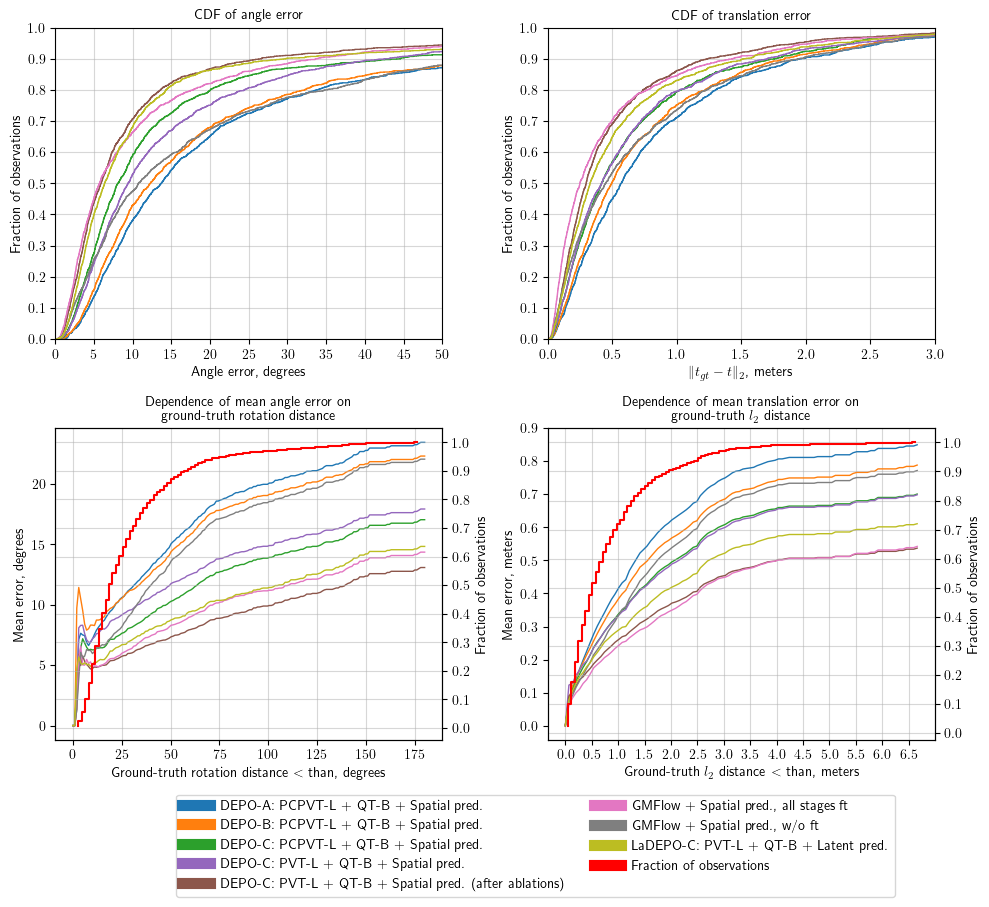

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#F08080', 
          '#87CEFA', '#FF6347', '#3CB371', '#FFA07A', '#FFD700',
          '#F0E68C', '#FF69B4', '#BA55D3', '#87CEEB']


exp_colors = {exp: col for  exp, col in zip(metrics.keys(), colors)}

for exp, m in metrics.items():
    sns.ecdfplot(x=m['R_angle_distances'], complementary=False, ax=ax[0,0], c=exp_colors[exp], linewidth=1)    

    sns.ecdfplot(x=m['t_distances_l2'], complementary=False, ax=ax[0,1], c=exp_colors[exp], linewidth=1, log_scale=False)

    R_on_gt = calculate_metric_on_subset(
        m['R_angle_distances'], m['R_gt_distances'], np.mean, np.linspace(0, 180, 180), '<')
    R_on_gt[np.isnan(R_on_gt)] = 0
    ax[1, 0].plot(np.linspace(0, 180, 180), R_on_gt, label=exp, c=exp_colors[exp], linewidth=1)
    
    t_on_gt = calculate_metric_on_subset(
        m['t_distances_l2'], m['t_gt_distances'], np.mean, np.linspace(0, 6.66, 100), '<')
    t_on_gt[np.isnan(t_on_gt)] = 0
    ax[1, 1].plot(np.linspace(0, 6.66, 100), t_on_gt, c=exp_colors[exp], linewidth=1)

    
    
ax[0, 0].set_xlim([0., 50.])
ax[0, 0].set_xticks(np.linspace(0, 50, 11, dtype='int'))
ax[0, 0].set_yticks(np.linspace(0, 1, 11))
ax[0, 0].set_ylabel('Fraction of observations')
ax[0, 0].set_xlabel('Angle error, degrees')
ax[0, 0].set_title('CDF of angle error')
ax[0, 0].grid(alpha=0.5)


ax[0, 1].set_xlim([0., 3.])
ax[0, 1].set_yticks(np.linspace(0, 1, 11))
ax[0, 1].set_ylabel('Fraction of observations')
ax[0, 1].set_xlabel('$\|t_{gt} - t\|_2$, meters')
ax[0, 1].set_title('CDF of translation error')
ax[0, 1].grid(alpha=0.5)


n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['R_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['R_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_10 = ax[1, 0].twinx() # create secondary axis with shared x-axis  
ax_10.step(bin_centers,cdf_values,'r', label='Fraction of observations')
ax_10.set_ylabel('Fraction of observations')
ax_10.set_yticks(np.linspace(0, 1, 11))
ax_10.grid(alpha=0.5)
ax[1, 0].set_xlabel('Ground-truth rotation distance $<$ than, degrees')
ax[1, 0].set_ylabel('Mean error, degrees')
ax[1, 0].set_title('Dependence of mean angle error on \n ground-truth rotation distance')
ax[1, 0].grid(axis='x', alpha=0.5)

n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['t_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['t_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_11 = ax[1, 1].twinx() # create secondary axis with shared x-axis  
ax_11.step(bin_centers, cdf_values, 'r', label='Fraction of observations')
ax_11.set_ylabel('Fraction of observations')
ax_11.set_yticks(np.linspace(0, 1, 11))
ax_11.grid(alpha=0.5)
ax[1, 1].set_xticks(np.linspace(0, 6.5, 14))
ax[1, 1].set_yticks(np.linspace(0, 0.9, 10))
ax[1, 1].set_xlabel('Ground-truth $l_2$ distance $<$ than, meters')
ax[1, 1].set_ylabel('Mean error, meters')
ax[1, 1].set_title('Dependence of mean translation error on \n ground-truth $l_2$ distance')
ax[1, 1].grid(axis='x', alpha=0.5)

handles, labels = ax[1, 0].get_legend_handles_labels()

handles.extend(ax_11.get_legend_handles_labels()[0])
labels.extend(ax_11.get_legend_handles_labels()[1])

from copy import copy
handles_ = [copy(ha) for ha in handles]
for h in handles_:
    h.set_linewidth(8)

fig.legend(handles_, labels, bbox_to_anchor=(.9, 0), borderaxespad=0.0, ncol=2)



fig.tight_layout()
plt.savefig('/home/project/code/results/paper/fig_1_cdfs_all_good.pdf', bbox_inches='tight')

In [125]:
metrics['LaDEPO-C: PVT-L + QT-B + Latent pred.']['R_angle_distances'][metrics['LaDEPO-C: PVT-L + QT-B + Latent pred.']['R_angle_distances'] < 25].mean()

7.0165815716194535

# Tab3: Choice of spatial regressor

In [126]:
with open('/home/project/code/results/scannet/metrics_flow', 'rb') as f:
    metrics_flow = pickle.load(f)

In [128]:
metrics_ = {}
for key, val in metrics_flow.items():
    metrics_[int(key.split('_')[1])] = val

In [129]:
exp_names = {
1: '(1) Baseline, shared decoder, init loss weights = [0, -3]', 
2: '(2) = (1) + $l_2$, init loss weights = [0, -3., 0]',
3: '(3) = (1) + LN',
4: '(4) = (2) + LN',
5: '(5) = (3) - LeakyReLU + ReLU',
6: '(6) = (4) - LeakyReLU + ReLU, init loss weights = [0, 0, 0]',
7: '(7) = (3) + Dropout, init loss weights = [0, -2]', 
8: '(8) = (4) + Dropout, init loss weights = [0, -2, 0.]',
9: '(9) = (4) +  init loss weights = [0, -2, 0]',
10: '(10) 2 separate heads, no weights in loss',
11: '(11) 3 separate heads, no weights in loss',
12: '(12) = (10) - LeakyReLU + ReLU',
13: '(13) = (4) but with ResNet blocks',
14: '(14) = (10) but with ResNet blocks',
15: '(15) = (14) with separable convs',
16: '(16) = (13) but first conv -> ASPP'
}

In [132]:
df = pd.DataFrame(index=metrics_.keys())

for q in (0.25, 0.5, 0.75, 0.9):
    df[f'$R_e^{q}$'] = None
    df[f'$t_e^{q}$'] = None
    for key, val in metrics_.items():
        df.loc[key, f'$t_e^{q}$'] = np.quantile(val["t_distances_l2"], q)
        df.loc[key, f'$R_e^{q}$'] = np.quantile(val["R_angle_distances"], q)
df.sort_index(axis=1, inplace=True)
df.sort_index(axis=0, inplace=True)

df.index = [exp_names[exp] for exp in df.index]
d = df.style.format(precision=2)
for col in df.columns:
    d.background_gradient(cmap="RdYlGn_r", subset=col)

d.to_latex(
    buf='/home/project/code/results/paper/tab_3_choice_of_regressor.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Choice of best spatial regressor. Results are given for relative pose estimation \textbf{with magnitude} on ScanNet test subset. Spatial regressors were trained on ground-truth flow.',
    label='tab:choice',
    hrules=True,
    clines='skip-last;data'
)

d

,$R_e^0.25$,$R_e^0.5$,$R_e^0.75$,$R_e^0.9$,$t_e^0.25$,$t_e^0.5$,$t_e^0.75$,$t_e^0.9$
"(1) Baseline, shared decoder, init loss weights = [0, -3]",2.42,5.09,11.50,29.16,0.13,0.26,0.60,1.58
"(2) = (1) + $l_2$, init loss weights = [0, -3., 0]",2.48,5.14,10.98,28.12,0.12,0.23,0.54,1.30
(3) = (1) + LN,1.67,3.33,7.92,22.00,0.11,0.21,0.54,1.19
(4) = (2) + LN,1.66,3.24,7.40,22.60,0.08,0.19,0.53,1.24
(5) = (3) - LeakyReLU + ReLU,1.92,3.48,7.37,20.48,0.10,0.20,0.55,1.30
"(6) = (4) - LeakyReLU + ReLU, init loss weights = [0, 0, 0]",2.17,4.17,9.20,25.36,0.08,0.15,0.37,1.05
"(7) = (3) + Dropout, init loss weights = [0, -2]",2.17,4.18,8.99,27.35,0.10,0.19,0.50,1.32
"(8) = (4) + Dropout, init loss weights = [0, -2, 0.]",2.17,4.27,9.62,25.41,0.09,0.20,0.50,1.18
"(9) = (4) + init loss weights = [0, -2, 0]",1.77,3.55,7.75,25.23,0.09,0.17,0.44,1.23
"(10) 2 separate heads, no weights in loss",1.84,3.60,8.26,25.53,0.08,0.15,0.36,1.06


# Tab4: Speed and parameters

In [4]:
df = pd.DataFrame({'# of parameters': [None], 'pairs/sec.': [None]}, index=['DEPO-C: PCPVT-L + QT-B + Spatial pred.', 'LaDEPO-C: PVT-L + QT-B + Latent pred.', 'GMFlow + Spatial pred.'])


In [6]:
df.loc['DEPO-C: PVT-L + QT-B + Spatial pred.'] = [12.89, '$18.42 \pm 0.26$']
df.loc['LaDEPO-C: PVT-L + QT-B + Latent pred.'] = [31.37, '$23.72 \pm$ 0.19$']
df.loc['GMFlow + Spatial pred.'] = [16.6, '$257.67 \pm 0.55']


d = df.style.format(precision=2)
d.to_latex(
    buf='/home/project/code/results/paper/tab_4_speed.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Models sizes and speed',
    label='tab:speed',
    hrules=True,
    clines='skip-last;data'
)

# Tab5: Inloc

In [151]:
d = {'Type': [None],
     'Method': [None],
     ('(0.25m, 2°) / (0.5m, 5°) / (5m, 10°)', 'DUC1'): None,
     ('(0.25m, 2°) / (0.5m, 5°) / (5m, 10°)', 'DUC2'): None,
    }


d = pd.DataFrame.from_dict(d)
d.loc[0] = ['detector-based', 'SIFT [2004] \cite{lowe2004distinctive} + MNN + Lowe *', '29.8 / 46.0 / 54.5','24.4 / 34.4 / 42.0']
d.loc[2] = ['detector-based', 'SuperPoint [2018] \cite{detone2018superpoint} + SuperGlue [2020] \cite{sarlin2020superglue}', 
            '49.0 / 68.7 / 80.8', '53.4 / 77.1 / 82.4']
d.loc[3] = ['semi-dense', 'LoFTR [2021] \cite{sun2021loftr}', '47.5 / 72.2 / 84.8', '54.2 / 74.8 /85.5']
d.loc[5] = ['semi-dense', 'MatchFormer [2022] \cite{wang2022matchformer}', '46.5 / 73.2 / 85.9', '55.7 / 71.8 / 81.7']
d.loc[6] = ['semi-dense', 'ASpanFormer [2022] \cite{chen2022aspanformer}', '51.5 / 73.7 / 86.4', '55.0 / 74.0 / 81.7']
d.loc[7] = ['semi-dense', 'DKM [2022] \cite{edstedt2022deep} **', '51.5 / 75.3 / 86.9', '63.4 / 82.4 / 87.8']
d.loc[8] = ['end-to-end', 'DEPO-C: PVT-L + QT-B + Spatial pred.', None, None]

d.set_index(['Type', 'Method'], inplace=True)
d.columns = pd.MultiIndex.from_tuples(d.columns).reorder_levels([0, 1])

d = d.style

d.index.names = [None, None]
d.to_latex(
    buf='/home/project/code/results/paper/tab_5_inlock.tex',
    position='h!',
    position_float='centering',
    sparse_index=True,
    multicol_align='c',
    convert_css=True,
    caption='Localization quality on InLoc',
    label='tab:inloc',
    hrules=True,
    clines='skip-last;data'
)

#* - estimated by me
#** - according to https://www.visuallocalization.net/benchmark/

d

In [152]:
metrics.keys()

dict_keys(['DEPO-A: PCPVT-L + QT-B + Spatial pred.', 'DEPO-B: PCPVT-L + QT-B + Spatial pred.', 'DEPO-C: PCPVT-L + QT-B + Spatial pred.', 'DEPO-C: PVT-L + QT-B + Spatial pred.', 'DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations)', 'GMFlow + Spatial pred., all stages ft', 'GMFlow + Spatial pred., w/o ft', 'LaDEPO-C: PVT-L + QT-B + Latent pred.'])